# Generate Continuity Graphs

Another task you can accomplish with patent_client is automatic generation of continuity graphs, like this one:

![continuity_graph](./img/tesla_continuity.svg)

To do this, we're going to use patent_client in conjunction with [pandas](https://pandas.pydata.org/) and [pygraphviz](https://graphviz.readthedocs.io/en/stable/index.html). PyGraphviz is a set of python bindings to the [GraphViz](https://www.graphviz.org/) data graph visualization library. We can use it to generate figures that illustrate the relationships between patent applications. 

Let's begin with the standard imports, and indicate one of the applications in the family of interest. Here, we've picked a patent application owned by Tesla as an example:

In [1]:
import pandas as pd
from patent_client_plus import USApplication

target = '15384723'

## Collect the Data

To collect all the data we need for our graph, we're going to need to iterate through the application, and every application related to it. We do that through an iterative algorithm that keeps a list of:

 - Applications it needs to retreive
 - Applications it has already retreived
 - Parent / Child data
 - A list of missing cases
 
Starting with the target patent, the algorithm retreives a case, records all the relationship data to the relevant lists, and adds a reference to the application itself to the applications list. With the data recorded, it then determines if any of the cases related to the current one haven't been visted yet. If they have not been visited, it adds them to the "to_visit" list. This process continues until the "to_visit" list is empty. The result is:

 - applications -> USApplication objects for the target and every related case
 - parent_entries -> Relationship objects for all parents of all applications
 - child_entries -> Relationship objects for all children of all applications
 - orphans -> application numbers for applications that were not found (typically an unpublished continuation application)
 

In [2]:
visited = list()
to_visit=[target,]

applications = list()
parent_entries = list()
child_entries = list()
orphans = list()

while to_visit:
    to_visit = list(sorted(to_visit))
    app_no = to_visit.pop(0)
    try:
        app = USApplication.objects.set_options(force_xml=False).get(app_no)
    except Exception as e:
        print(e, app_no)
        visited.append(app_no)
        orphans.append(app_no)
        continue
    applications.append(app)

    parent_entries += app.parents
    child_entries += app.children
    related_app_nos = [a.appl_id for a in app.parents + app.children]
    
    for app in related_app_nos:
        if (app not in visited and app not in to_visit):
            to_visit.append(app)
    visited.append(app_no)

For every application, the parent records indicate a clear relationship - e.g. continuation / divisional / etc, so we're only going to work with the parent entry data, which we can convert to a Pandas dataframe as:

In [3]:
cont_df = pd.DataFrame.from_records(r.as_dict() for r in parent_entries)
cont_df.head()

,appl_id,filing_date,patent_number,related_to_appl_id,relationship,status
0,14862609,2015-09-23,9527406,15384723,is a Continuation of,Patented
1,14281679,2014-05-19,9162586,15384723,is a Continuation of,Patented
2,13866214,2013-04-19,8761985,15384723,is a Continuation of,Patented
3,12782413,2010-05-18,8453770,15384723,is a Division of,Patented
4,12322218,2009-01-29,None,15384723,is a Continuation in part of,Abandoned


## Filter the Relationships

Now we have a problem. If we just graph this data, we get a total jumble. A lot of this parent data is duplicated. For example, assume we have 3 applications in the following relationship:

`Application A - is a CON of - Application B - is a CON of - Application C`

From the data we've pulled, we'll see three separate records:

| child | relationship | parent |
|-------|--------------|--------|
| A     | is a CON of  | B      |
| B     | is a CON of  | C      |
| A     | is a CON of  | C      |

But we only want two records. We don't care if A is a CON of C, because when we produce the graph, that will be shown by the fact that A is a CON of B, which is a CON of C. So we need to simplify the records. We use another algorithm.

Here, we iterate through each application, and pull all of its parents. We then iterate through each of its parents to determine grandparents. Any grandparents found are removed from the list of parents, and the surviving entries are added to a "filtered_cont_df" dataframe.

In [4]:
filtered_cont_df = pd.DataFrame()

for app in applications:
    parents = cont_df[cont_df['related_to_appl_id'] == app.appl_id]
    parent_ids = set(parents['appl_id'])
    for p in list(parent_ids):
        grand_parents = list(cont_df[cont_df['related_to_appl_id'] == p]['appl_id'])
        parent_ids = parent_ids - set(grand_parents)
    filtered_cont_df = pd.concat([filtered_cont_df, parents[parents['appl_id'].isin(parent_ids)]])

print(f'Compressed {len(cont_df)} relationships into {len(filtered_cont_df)} relationships')    
    

Compressed 25 relationships into 10 relationships


## Make the Relationships Look Nice

Now we're going to modify the filtered_cont_df DataFrame to make it look nicer. We will simplify each of the relationship types into neat 2-3 letter codes.

In [5]:
def assign_identifiers(string):
    string = string.lower()
    if ('continuation-in-part' in string 
        or 'continuation in part' in string):
        return 'CIP'
    elif 'continuation' in string:
        return 'CON'
    elif 'division' in string:
        return 'DIV'
    elif 'provisional' in string:
        return 'PRV'
    elif 'stage' in string:
        return 'NS'

filtered_cont_df['relationship'] = filtered_cont_df['relationship'].apply(assign_identifiers)


## Generate the Graph

Now for the heavy-lifting. This is going to proceed in two stages. 

1. We're going to add in `node` objects for each application, with text that's descriptive of the case
2. We're going to add `edge` objects for each relationship, with the relationship code

The result can then be displayed in the notebook by simply calling the Graph object (dot), or by calling dot.render() GraphViz will save a file to disk containing the image.

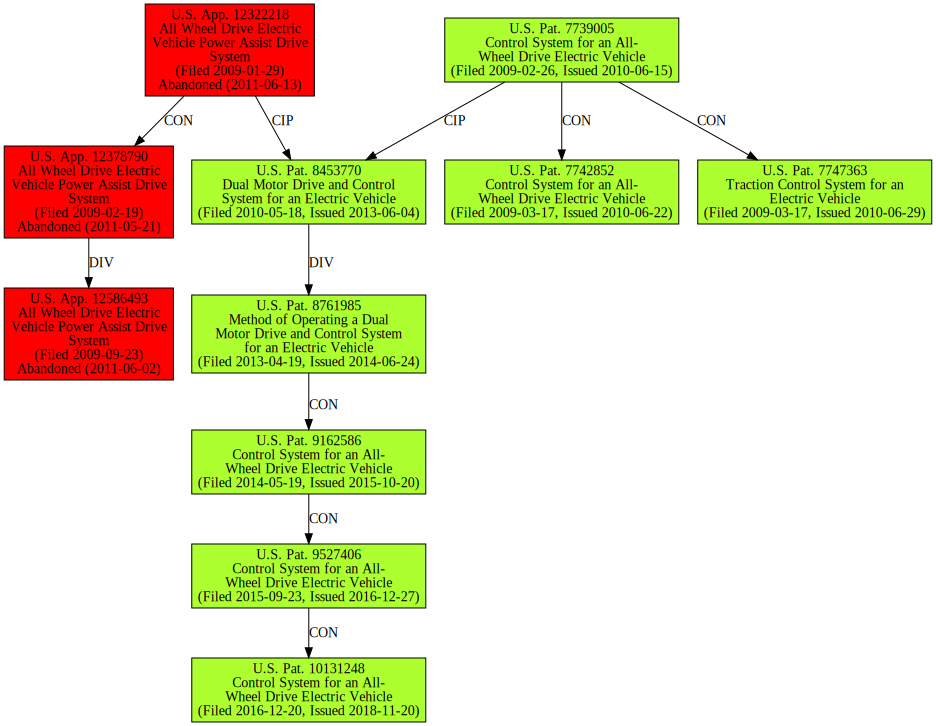

In [6]:
from graphviz import Digraph
import textwrap
from titlecase import titlecase
from collections import OrderedDict
import datetime

# Create the Graph Object
dot = Digraph(format='svg', node_attr={'shape': 'rectangle', 'style': 'filled'})

# Stage 1 - Add the Nodes
for app in applications:
    title = '\n'.join(textwrap.wrap(titlecase(app.patent_title), 30))
    string = 'U.S. App. ' + app.appl_id + f"\n{title}\n(Filed {app.app_filing_date})"
    color = 'orange'
    
    # Color PCT applications aquamarine
    if 'PCT' in string:
        string = f'{app.appl_id}'
        color = 'aquamarine'
    
    # Add patent information for issued patents
    elif hasattr(app, 'patent_number'):
        string = f'U.S. Pat. {app.patent_number}\n{title}\n(Filed {app.app_filing_date}, Issued {app.patent_issue_date})'
        color = 'greenyellow'
    
    elif hasattr(app, 'app_early_pub_number'):
        status_text = app.app_status.split('-')[0].replace('Mailed', '').replace('Filed', '').replace(',', '\n').strip()
        status = f"{status_text} ({app.app_status_date})"
        string = string + f'\n{status}'
        if 'abandon' in app.app_status.lower():
            color = 'red'
        else:
            color = 'lightblue'
    
    dot.node(app.appl_id, string, fillcolor=color)

# Stage 2 - add the Edges
for i, connection in filtered_cont_df.iterrows():
        dot.edge(connection['appl_id'], connection['related_to_appl_id'], connection['relationship'], splines='ortho')
    
dot#.render()